In [154]:
import tensorflow as tf
import numpy as np
import json
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to resize labels
def resize_labels(labels, original_size, new_size):
    # Adjust the label coordinates for the new image size
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels


# Function to convert labels to EfficientDet format
def convert_to_efficientdet_format(labels, image_shape):
    efficientdet_labels = []
    for label in labels:
        # Calculate the coordinates of the upper left and lower right corners
        xmin = (label['x'] - label['radius']) / image_shape[1]
        ymin = (label['y'] - label['radius']) / image_shape[0]
        xmax = (label['x'] + label['radius']) / image_shape[1]
        ymax = (label['y'] + label['radius']) / image_shape[0]
        # EfficientDet format [ymin, xmin, ymax, xmax]
        efficientdet_labels.append([
            max(0, ymin), max(0, xmin), min(1, ymax), min(1, xmax)
        ])
    return efficientdet_labels


# Function to load images and labels
def load_images_and_labels(image_dir, label_dir, original_size=(1024, 1024), new_size=(512, 512)):
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]
    
    images = []
    all_boxes = []

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        image = load_img(image_file, color_mode='rgb', target_size=new_size)
        # Convert the image to an array and scale the pixel values to [-1, 1]
        image = (img_to_array(image) / 127.5) - 1
        images.append(image)

        # Load labels and adjust for new image size
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size=original_size, new_size=new_size)
        boxes = convert_to_efficientdet_format(resized_json_data, new_size)
        all_boxes.append(boxes)
    
    return np.array(images), all_boxes


# Function to pad labels to a fixed size
def pad_labels(labels, max_boxes=250, pad_value=0):
    padded_labels = []
    for label in labels:
        padded_label = np.zeros((max_boxes, 4), dtype=np.float32) + pad_value
        num_boxes = min(len(label), max_boxes)
        padded_label[:num_boxes] = label[:num_boxes]
        padded_labels.append(padded_label)
    return np.array(padded_labels)

# Function to prepare the dataset
def prepare_dataset(images, boxes, batch_size, num_boxes=250):
    images = tf.constant(images, dtype=tf.float32)
    boxes = pad_labels(boxes, max_boxes=num_boxes)
    boxes = tf.constant(boxes, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((images, boxes))
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [155]:
batch_size = 2
image_dir = './TMA_WSI_Padded_PNGs'
label_dir = './TMA_WSI_Labels_updated'
images, boxes = load_images_and_labels(image_dir, label_dir)
# Map this preprocessing function to your dataset


# Assuming we have only one class for object detection and 100 boxes per image
num_boxes = 250  # Maximum number of boxes per image, adjust as needed

dataset = prepare_dataset(images, boxes, batch_size, num_boxes=num_boxes)

In [184]:
pad_labels(boxes)

array([[[0.75595856, 0.03125763, 0.7969742 , 0.07227325],
        [0.5645523 , 0.03321075, 0.60556793, 0.07422638],
        [0.7946928 , 0.03579737, 0.83570844, 0.07681299],
        ...,
        [0.74785924, 0.928589  , 0.78887486, 0.9696046 ],
        [0.5092229 , 0.93155664, 0.55023855, 0.97257227],
        [0.5850601 , 0.93164825, 0.62607574, 0.9726639 ]],

       [[0.5468646 , 0.02054571, 0.58788025, 0.06156134],
        [0.5049247 , 0.02233419, 0.54594034, 0.06334982],
        [0.6241188 , 0.02246857, 0.66513443, 0.06348419],
        ...,
        [0.7223731 , 0.92255545, 0.76338875, 0.9635711 ],
        [0.6397438 , 0.92676544, 0.68075943, 0.96778107],
        [0.60263443, 0.927742  , 0.64365005, 0.9687576 ]],

       [[0.60313076, 0.03715441, 0.6441464 , 0.07817004],
        [0.43369293, 0.04395294, 0.47470856, 0.08496857],
        [0.48349762, 0.04395294, 0.52451324, 0.08496857],
        ...,
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.      

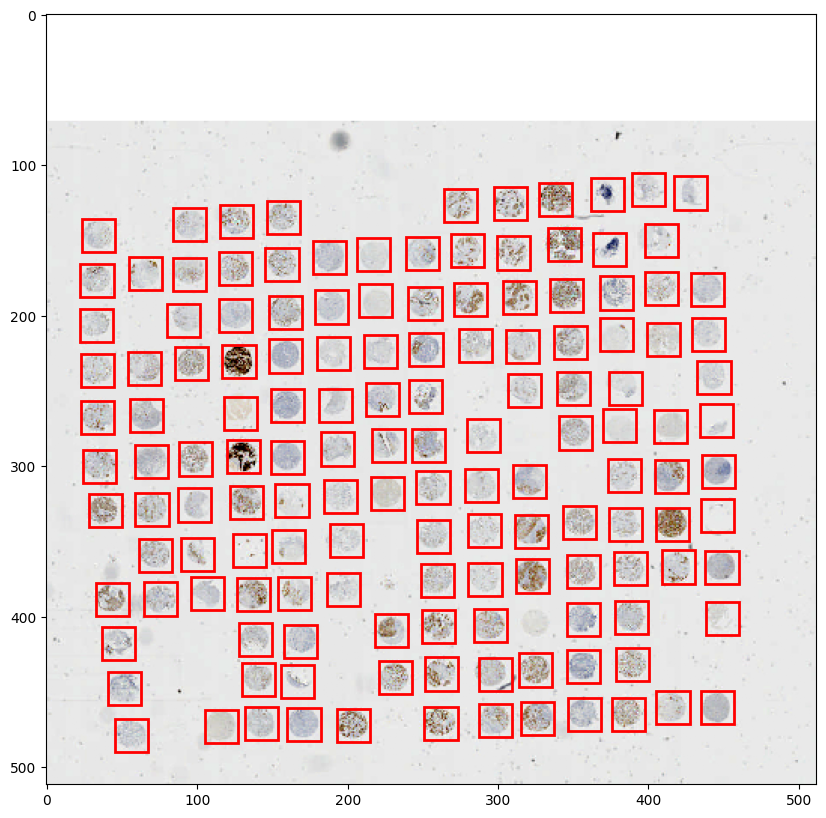

In [156]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_boxes(image, boxes, figsize=(10, 10)):
    """
    Plots an image with overlaid bounding boxes.

    Args:
    image: The image as a NumPy array.
    boxes: A NumPy array of bounding boxes of shape (N, 4), where N is the number of boxes,
           and each box is defined as (ymin, xmin, ymax, xmax).
    figsize: Size of the figure to display.
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap='gray')  # Assuming the image is grayscale, adjust colormap if not

    img_height, img_width = image.shape[:2]
    for box in boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Example usage:
# Assuming `images` is your array of images loaded from the dataset and
# `boxes` is the array of bounding boxes for the corresponding images.
# Here we visualize the first image and its boxes.
plot_image_with_boxes(images[10], boxes[10])


In [157]:
import tensorflow as tf
from tensorflow.keras import layers, models
def create_object_detection_model(num_boxes):
    backbone = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False, weights='imagenet')
    backbone.trainable = False

    x = backbone.output
    x = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer for bounding box predictions
    # The output is reshaped to [batch_size, num_boxes, 4]
    boxes_output_flat = layers.Dense(num_boxes * 4, activation='sigmoid', name='boxes_output')(x)
    boxes_output = layers.Reshape((num_boxes, 4))(boxes_output_flat)

    model = models.Model(inputs=backbone.input, outputs=boxes_output)
    
    return model


model = create_object_detection_model(num_boxes)

In [158]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 256, 32)         864       ['input_16[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 256, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 256, 256, 32)         0         ['bn_Conv1[0][0]']     

In [177]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import datetime
import os

# Define the Smooth L1 Loss Function
def smooth_l1_loss(sigma=3.0):
    sigma_squared = sigma ** 2
    
    def smooth_l1_loss_fixed(y_true, y_pred):
        regression_diff = y_true - y_pred
        regression_diff = tf.abs(regression_diff)
        regression_loss = tf.where(
            tf.less(regression_diff, 1.0 / sigma_squared),
            0.5 * sigma_squared * tf.pow(regression_diff, 2),
            regression_diff - 0.5 / sigma_squared
        )
        regression_loss = tf.reduce_sum(regression_loss, axis=-1)
        return tf.reduce_mean(regression_loss)
    
    return smooth_l1_loss_fixed
# Compile the Model with the Custom Loss
model.compile(optimizer='adam',
              loss=smooth_l1_loss(),  # Only use smooth L1 loss for bounding box predictions
              metrics=['mean_squared_error'])  # Added a metric for bounding box prediction quality

# Set up TensorBoard logging
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Set up checkpoints to save the model
checkpoint_dir = "checkpoints/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = checkpoint_dir + "cp-{epoch:04d}.ckpt"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=False  # Set to True to save only the best model based on validation loss
)

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch%10 == 0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr

learning_rate_callback = LearningRateScheduler(scheduler)




In [178]:
# Fit the Model on the Prepared Dataset
# The dataset should output a tuple of (images, boxes)
history = model.fit(
    dataset,
    epochs=500,
    callbacks=[tensorboard_callback, checkpoint_callback, learning_rate_callback])  # Add the callbacks here

Epoch 1/500
10/10 [==============================] - ETA: 0s - loss: 0.0066 - mean_squared_error: 3.8920e-04
Epoch 1: saving model to checkpoints/cp-0001.ckpt
10/10 [==============================] - 3s 189ms/step - loss: 0.0066 - mean_squared_error: 3.8920e-04 - lr: 0.0010
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.0262 - mean_squared_error: 0.0015
Epoch 2: saving model to checkpoints/cp-0002.ckpt
10/10 [==============================] - 2s 201ms/step - loss: 0.0264 - mean_squared_error: 0.0015 - lr: 0.0010
Epoch 3/500
10/10 [==============================] - ETA: 0s - loss: 0.0126 - mean_squared_error: 7.2372e-04
Epoch 3: saving model to checkpoints/cp-0003.ckpt
10/10 [==============================] - 2s 199ms/step - loss: 0.0126 - mean_squared_error: 7.2372e-04 - lr: 0.0010
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.0100 - mean_squared_error: 5.7870e-04
Epoch 4: saving model to checkpoints/cp-0004.ckpt
10/10 [=================

In [179]:
model.save('TMA_core_predictor.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 80ms/step


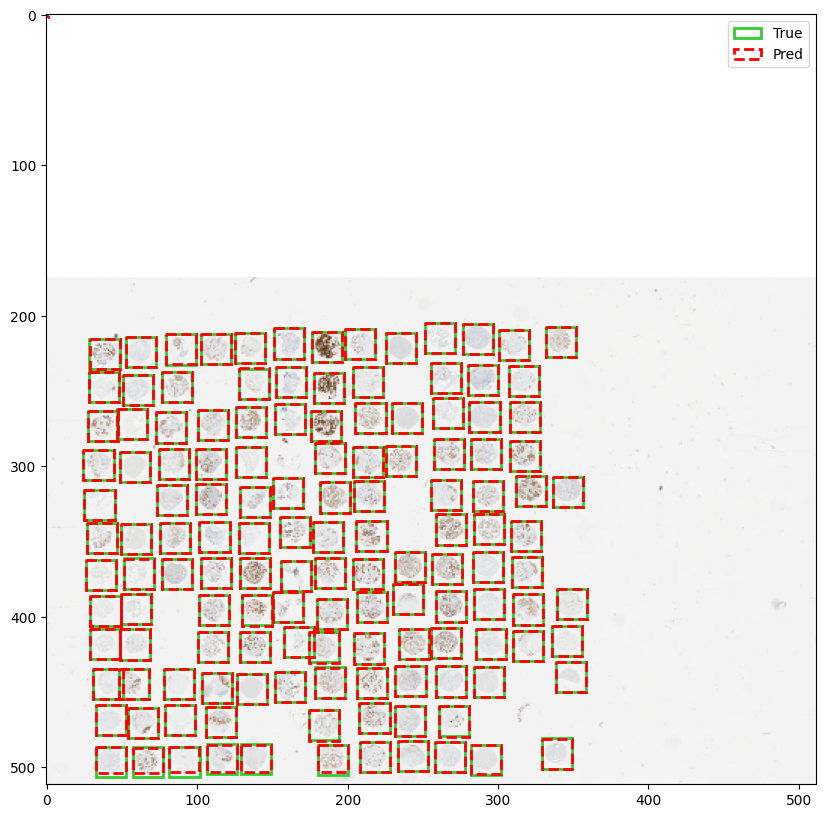

In [193]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_boxes(image, true_boxes, pred_boxes, figsize=(10, 10)):
    """
    Plots an image with overlaid true and predicted bounding boxes, ensuring visibility even when boxes overlap.
    
    Args:
    image: The image as a NumPy array, normalized between [-1, 1].
    true_boxes: A NumPy array of true bounding boxes of shape (N, 4), where N is the number of boxes,
                and each box is defined as (ymin, xmin, ymax, xmax).
    pred_boxes: A NumPy array of predicted bounding boxes of shape (N, 4), similar to true_boxes.
    figsize: Size of the figure to display.
    """
    # Rescale the image from [-1,1] to [0,1] for displaying
    image = (image + 1) / 2.0

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)  # If the image is not grayscale, remove cmap='gray'

    img_height, img_width = image.shape[:2]
    
    # Plot true bounding boxes
    for box in true_boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        # Use a solid line for true boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='limegreen', facecolor='none', linestyle='-', label='True')
        ax.add_patch(rect)
    
    # Plot predicted bounding boxes
    for box in pred_boxes:
        if np.all(box == 0):
            continue  # Skip boxes that are all zeros (used for padding)
        ymin, xmin, ymax, xmax = box
        ymin *= img_height
        ymax *= img_height
        xmin *= img_width
        xmax *= img_width
        # Use a dashed line for predicted boxes
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none', linestyle='--', alpha=1, label='Pred')
        ax.add_patch(rect)

    # Create a legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # This ensures that only one label for each line style is added to the legend
    unique_labels = list(set(labels))
    unique_handles = [by_label[label] for label in unique_labels]
    ax.legend(unique_handles, unique_labels)
    
    plt.show()


image = 5 # Select an index of an image to display

pred_boxes = model.predict(images[image:image+1])  # Predict the bounding boxes for the 11th image
# Rescale predictions if necessary here

true_boxes = pad_labels(boxes)


plot_image_with_boxes(images[image], true_boxes[image], pred_boxes[0])
